In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import pdb

## Load Data

In [32]:
data_raw = pd.read_csv('college_admissions.csv')

# Create dummies
temp = pd.get_dummies(data_raw['rank'], prefix='rank')
data = pd.concat([data_raw, temp], axis=1)
data.drop(columns='rank', inplace=True)

# Normalize
for col in ['gre', 'gpa']:
    mean, std = data[col].mean(), data[col].std()
    # data.loc[:, col] = (data[col]-mean) / std
    data[col] = (data[col]-mean) / std

# Split off random 10% of the data for testing
np.random.seed(42)
sample = np.random.choice(data.index, size=int(len(data)*0.9), replace=False)
data, test_data = data.iloc[sample], data.drop(sample)

# Split into features and targets
#features, targets = data.drop('admit', axis=1), data['admit']
#features_test, targets_test = test_data.drop('admit', axis=1), test_data['admit']

## Explore Data

In [27]:
# features[features.rank_1 == 1].hist()
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit    400 non-null int64
gre      400 non-null int64
gpa      400 non-null float64
rank     400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


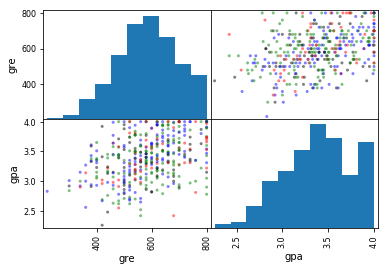

In [28]:
cmap = {1: 'red', 2:'green', 3:'blue', 4:'black'}
colors = data_raw['rank'].apply(lambda cc:cmap[cc])
pd.plotting.scatter_matrix(data_raw[['gre', 'gpa']], c=colors);

## Do some backprop functions

In [29]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1-sigmoid(x))

def fwd(x, W):
    z = x @ W
    return sigmoid(z), z

def loss(x, y, W):
    y_hat = sigmoid(x @ W)
    # no inner sum becouse single output
    return .5 * np.mean((y-y_hat)**2)

def backprop(x, y, W, lr):
    # Forward pass
    y_hat, z = fwd(x, W)
    
    # Backward pass
    ro = (y-y_hat) * -sigmoid_deriv(z)
    del_W = (x.T @ ro) / len(x)
    
    return del_W
    
    
def ngrad(x, y, W):
    # Check gradient numerically
    eps = 1e-4
    del_W = np.zeros_like(W)    
    for r in range(W.shape[0]):
        for c in range(W.shape[1]):
            W_min = W.copy()
            W_pls = W.copy()
            
            W_min[r, c] -= eps
            W_pls[r, c] += eps
            
            l_pls = loss(x, y, W_pls)
            l_min = loss(x, y, W_min)

            del_W[r, c] = (l_pls - l_min) / (eps * 2)
    return del_W
        

## Training loop

Initialize neural net

In [30]:
n_hid = 1
nb_epochs = 1000
lr = 0.5

np.random.seed(42)
n_inputs = features.shape[1]
W_hid = np.random.normal(scale=n_inputs**-.5, size=[n_inputs, n_hid])

Main train loop

In [31]:
for e in range(nb_epochs):
    x = features.values
    y = targets.values[:,None]
    
#     x = x[0:1]  # test on one row
#     y = y[0:1]
    
    assert x.ndim == 2 and x.shape[1] == 6
    assert y.ndim == 2 and y.shape[1] == 1
    
    del_W = backprop(x, y, W_hid, lr)
    W_hid += -lr * del_W   
        
    if e % (nb_epochs / 10) == 0:
        loss_test = loss(x, y, W_hid)
        
        x_test = features_test.values
        y_test = targets_test.values[:,None]
        predictions, _ = fwd(x_test, W_hid)
        predictions = predictions > 0.5
        acc_test = np.mean(predictions == y_test)
        
        print('loss {0}, tacc {1:.3f}'.format(
            loss_test, acc_test))
    



loss 0.13138046924983174, tacc 0.475
loss 0.10464309704662438, tacc 0.775
loss 0.10042146454036713, tacc 0.750
loss 0.09931078237763936, tacc 0.725
loss 0.09889925698343013, tacc 0.725
loss 0.09871288956094934, tacc 0.725
loss 0.09861753873120528, tacc 0.725
loss 0.0985647281254624, tacc 0.725
loss 0.09853383170657541, tacc 0.725
loss 0.09851502900888688, tacc 0.725


**Correct output is:**
```
loss 0.13138046924983174, tacc 0.475
loss 0.10464309704662438, tacc 0.775
loss 0.10042146454036713, tacc 0.750
loss 0.09931078237763936, tacc 0.725
loss 0.09889925698343013, tacc 0.725
loss 0.09871288956094934, tacc 0.725
loss 0.09861753873120528, tacc 0.725
loss 0.0985647281254624, tacc 0.725
loss 0.09853383170657541, tacc 0.725
loss 0.09851502900888688, tacc 0.725
```